In [1]:
!pip install colorgram.py

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.patches import Circle, Rectangle
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
import colorgram
import textwrap

#list all files under the input directory to find the exact path of Book_Details.csv
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/crash-txt/Crashnumberinggothic-MAjp.ttf
/kaggle/input/books-dataset-goodreadsmay-2024/books.db
/kaggle/input/books-dataset-goodreadsmay-2024/book_reviews.db
/kaggle/input/books-dataset-goodreadsmay-2024/Book_Details.csv
/kaggle/input/cookiesmallman/CookiesmallmanRegular-VGeXZ.ttf
/kaggle/input/tomato-font/Tomatoes-O8L8.ttf


In [3]:
file_path = '/kaggle/input/books-dataset-goodreadsmay-2024/Book_Details.csv'

In [4]:
#load the CSV file into a pandas DataFrame
books_df = pd.read_csv(file_path)

In [5]:
print(books_df.head())

   Unnamed: 0  book_id                                    cover_image_uri  \
0           0        1  https://images-na.ssl-images-amazon.com/images...   
1           1        2  https://images-na.ssl-images-amazon.com/images...   
2           2        3  https://images-na.ssl-images-amazon.com/images...   
3           3        5  https://images-na.ssl-images-amazon.com/images...   
4           4        6  https://images-na.ssl-images-amazon.com/images...   

                                  book_title  \
0     Harry Potter and the Half-Blood Prince   
1  Harry Potter and the Order of the Phoenix   
2      Harry Potter and the Sorcerer's Stone   
3   Harry Potter and the Prisoner of Azkaban   
4        Harry Potter and the Goblet of Fire   

                                        book_details  \
0  It is the middle of the summer, but there is a...   
1  Harry Potter is about to start his fifth year ...   
2  Harry Potter has no idea how famous he is. Tha...   
3  Harry Potter, along w

In [6]:
print(books_df.columns)

Index(['Unnamed: 0', 'book_id', 'cover_image_uri', 'book_title',
       'book_details', 'format', 'publication_info', 'authorlink', 'author',
       'num_pages', 'genres', 'num_ratings', 'num_reviews', 'average_rating',
       'rating_distribution'],
      dtype='object')


In [7]:
cover_image_uri = books_df['cover_image_uri'].iloc[0]
print(cover_image_uri)

https://images-na.ssl-images-amazon.com/images/S/compressed.photo.goodreads.com/books/1587697303i/1.jpg


In [8]:
#for long book titles == wrap text after 25 characters
def wrap_text(text, width=25):
    return '\n'.join(textwrap.wrap(text, width=width))

In [9]:
#rank the books by average rating and number of ratings
books_df['rating_rank'] = books_df['average_rating'].rank(ascending=False, method='min')
books_df['num_ratings_rank'] = books_df['num_ratings'].rank(ascending=False, method='min')

#sum the ranks
books_df['combined_rank'] = books_df['rating_rank'] + books_df['num_ratings_rank']

#sort the DataFrame by combined rank
sorted_books = books_df.sort_values('combined_rank')

#top 10 books (unique authors)
unique_authors = set()
top_books = []

for _, row in sorted_books.iterrows():
    if row['author'] not in unique_authors:
        top_books.append(row)
        unique_authors.add(row['author'])
    if len(top_books) == 10:
        break

top_books_df = pd.DataFrame(top_books)

In [10]:
#get the dominant color of each book cover
def get_dominant_color(image_url):
    try:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
        colors = colorgram.extract(img, 1)
        if colors:
            rgb = colors[0].rgb
            return (rgb.r, rgb.g, rgb.b)
        else:
            return (0, 0, 0)
    except Exception as e:
        print(f"Error: {e}")
        return (0, 0, 0)

def rgb_to_hex(rgb):
    return "#{:02x}{:02x}{:02x}".format(rgb[0], rgb[1], rgb[2])

In [11]:
#more info on the dataset
total_books = len(books_df)
avg_rating_overall = books_df['average_rating'].mean()
most_rated_book = books_df.loc[books_df['num_ratings'].idxmax()]['book_title']
most_rated_book_ratings = books_df['num_ratings'].max()

In [12]:
#load custom font == https://www.fontspace.com/tomatoes-font-f29709
font_path = '/kaggle/input/tomato-font/Tomatoes-O8L8.ttf'

In [13]:
font_properties = fm.FontProperties(fname=font_path)

In [14]:
#load custom font == https://www.fontspace.com/crash-numbering-font-f3373
font_path = '/kaggle/input/crash-txt/Crashnumberinggothic-MAjp.ttf'

In [15]:
font_properties2 = fm.FontProperties(fname=font_path)

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


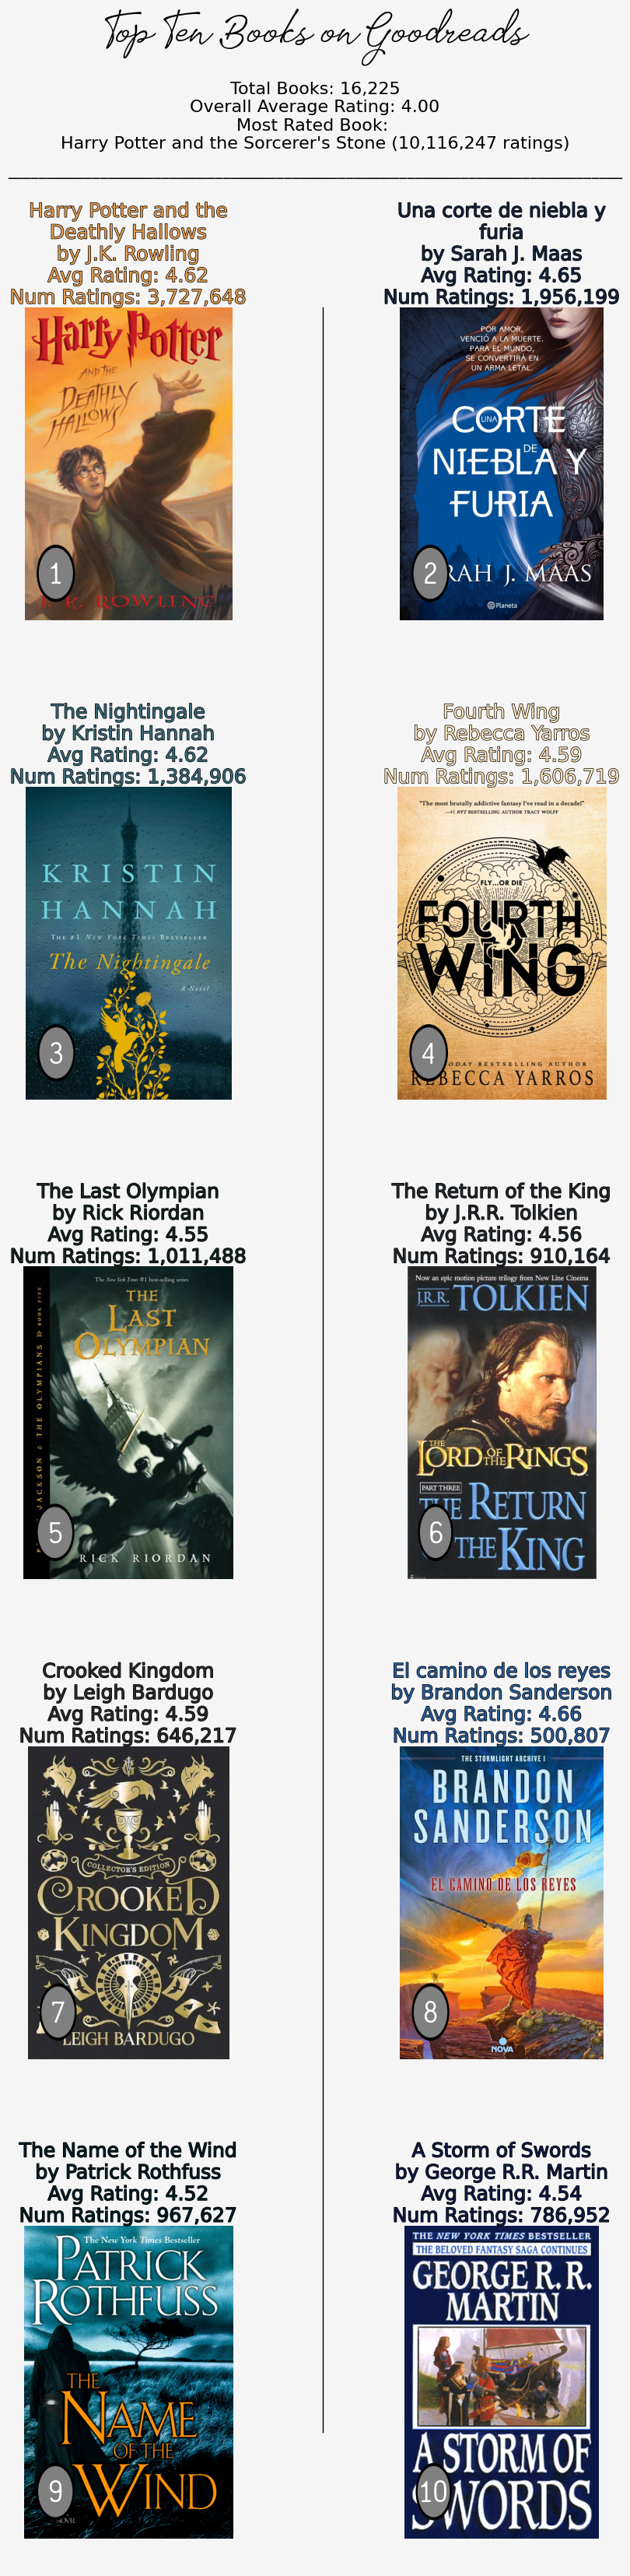

In [16]:
#generate infographic - top ten books
fig = plt.figure(figsize=(20, 35), facecolor='whitesmoke') 
fig.suptitle('Top Ten Books on Goodreads', fontsize=26, color='black', fontproperties=font_properties, y=0.99)

stats_text = (f"Total Books: {total_books:,}\n"
              f"Overall Average Rating: {avg_rating_overall:.2f}\n"
              f"Most Rated Book: \n{most_rated_book} ({most_rated_book_ratings:,} ratings)")

fig.text(0.5, 0.95, stats_text, ha='center', va='center', fontsize=16, color='black')

#divider
fig.text(0.5, 0.93, "_" * 80, ha='center', va='center', color='black', fontsize=14)

#subplots for the book covers and information
fig.subplots_adjust(hspace=0.4, top=0.88) 
axs = fig.subplots(5, 2, gridspec_kw={'height_ratios': [3, 3, 3, 3, 3], 'wspace': 0.5}) 
plt.rcParams.update({'font.family': 'Palatino Linotype'})

for idx, (ax, (index, row)) in enumerate(zip(axs.flatten(), top_books_df.iterrows())):
    book_name = wrap_text(row['book_title'], width=25)
    author = row['author']
    avg_rating = row['average_rating']
    num_ratings = row['num_ratings']
    cover_image_uri = row['cover_image_uri']

    try:
        response = requests.get(cover_image_uri)
        img = Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Error loading image: {e}")
        continue

    dominant_color = get_dominant_color(cover_image_uri)
    hex_color = rgb_to_hex(dominant_color)

    ax.imshow(img)
    ax.axis('off')  
    
    ax.set_aspect('equal', adjustable='datalim')

    circle_radius = 0.08
    circle_border_radius = 0.09
    circle_x = 0.15
    circle_y = 0.15
    circle_color = 'gray'
    circle_border_color = 'black'
    
    circle_border = Circle((circle_x, circle_y), circle_border_radius, color=circle_border_color, transform=ax.transAxes, zorder=5)
    circle = Circle((circle_x, circle_y), circle_radius, color=circle_color, transform=ax.transAxes, zorder=6)
    
    ax.add_patch(circle_border)
    ax.add_patch(circle)
    adjustment = 0.01  
    ax.text(circle_x, circle_y + adjustment, str(idx + 1), color='white', fontsize=30, ha='center', va='center', transform=ax.transAxes, zorder=7, fontproperties=font_properties2)

    text = (f"{book_name}\nby {author}\n"
            f"Avg Rating: {avg_rating:.2f}\n"
            f"Num Ratings: {num_ratings:,}")
    
    title_text = ax.set_title(text, fontsize=18, pad=1, color=hex_color)
    title_text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                 path_effects.Normal()])
    
    #divider between books - not used/transparent
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="7%", pad=0.1)
    cax.plot([0, 1], [1, 1], color='none', linewidth=0)
    cax.axis('off')

#vertical divider line
fig.add_artist(plt.Line2D([0.505, 0.505], [0.1, 0.88], color='black', linewidth=1, transform=fig.transFigure))

#position of the subplots within the figure
plt.subplots_adjust(left=0.3, right=0.70, top=0.88, bottom=0.05)
#plt.savefig('top_10_books_infographic.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
#bottom 10 books
#filter books with at least a 1.0 rating and at least 15,000 ratings -> adjust as needed
filtered_books_df = books_df[(books_df['average_rating'] >= 1.0) & (books_df['num_ratings'] >= 15000)].copy() 

filtered_books_df.loc[:, 'rating_rank'] = filtered_books_df['average_rating'].rank(ascending=True, method='min')
filtered_books_df.loc[:, 'num_ratings_rank'] = filtered_books_df['num_ratings'].rank(ascending=True, method='min')

filtered_books_df.loc[:, 'combined_rank'] = filtered_books_df['rating_rank'] + filtered_books_df['num_ratings_rank']

sorted_books3 = filtered_books_df.sort_values('combined_rank')

unique_authors1 = set()
bottom_books = []

for _, row in sorted_books3.iterrows():
    if row['author'] not in unique_authors1:
        bottom_books.append(row)
        unique_authors1.add(row['author'])
    if len(bottom_books) == 10:
        break

bottom_books_df = pd.DataFrame(bottom_books)

In [18]:
#more info on the dataset
total_ratings_bottom_ten = bottom_books_df['num_ratings'].sum()
least_rated_book = bottom_books_df.loc[bottom_books_df['num_ratings'].idxmin()]['book_title']
least_rated_book_ratings = bottom_books_df['num_ratings'].min()

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


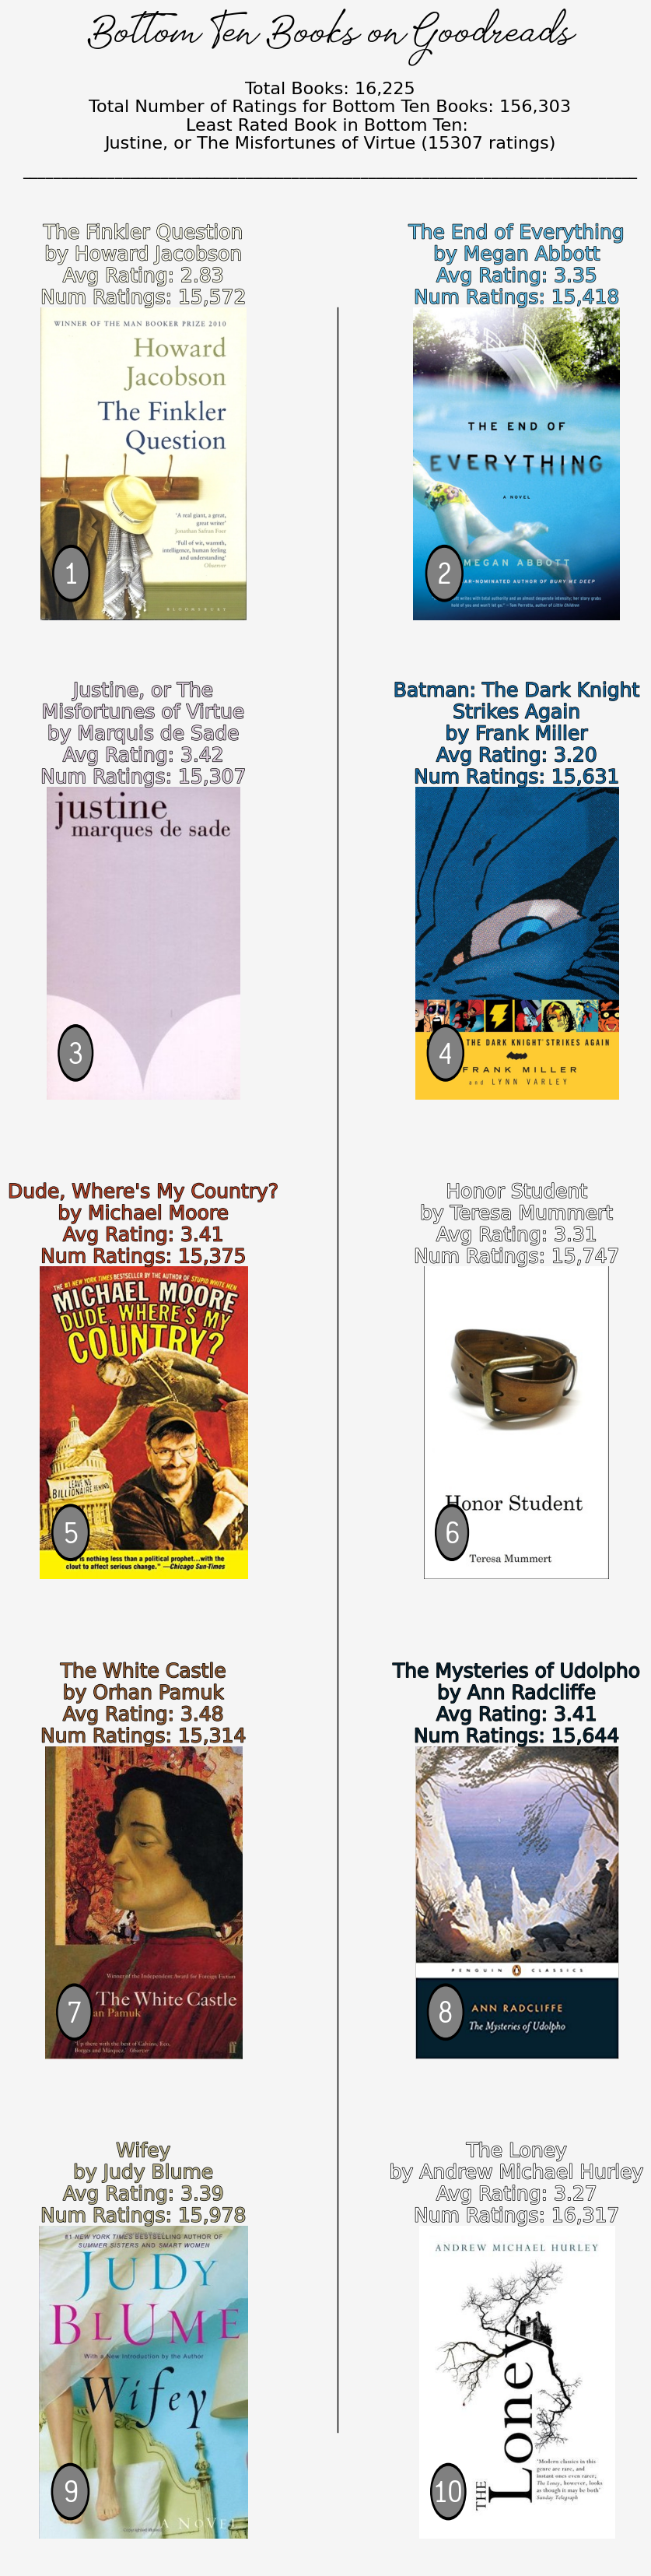

In [19]:
#generate the infographic bottom ten books
fig = plt.figure(figsize=(20, 35), facecolor='whitesmoke')
fig.suptitle('Bottom Ten Books on Goodreads', fontsize=26, color='black', fontproperties=font_properties, y=0.99)

stats_text = (f"Total Books: {total_books:,}\n"
              f"Total Number of Ratings for Bottom Ten Books: {total_ratings_bottom_ten:,}\n"
              f"Least Rated Book in Bottom Ten: \n{least_rated_book} ({least_rated_book_ratings} ratings)")
              
fig.text(0.5, 0.95, stats_text, ha='center', va='center', fontsize=16, color='black')
fig.text(0.5, 0.93, "_" * 80, ha='center', va='center', color='black', fontsize=14) #divider

#subplots for the book covers and information
fig.subplots_adjust(hspace=0.4, top=0.88) 
axs = fig.subplots(5, 2, gridspec_kw={'height_ratios': [3, 3, 3, 3, 3], 'wspace': 0.5}) 
plt.rcParams.update({'font.family': 'Palatino Linotype'})

for idx, (ax, (index, row)) in enumerate(zip(axs.flatten(), bottom_books_df.iterrows())):
    book_name = wrap_text(row['book_title'], width=25)
    author = row['author']
    avg_rating = row['average_rating']
    num_ratings = row['num_ratings']
    cover_image_uri = row['cover_image_uri']

    try:
        response = requests.get(cover_image_uri)
        img = Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Error loading image: {e}")
        continue

    dominant_color = get_dominant_color(cover_image_uri)
    hex_color = rgb_to_hex(dominant_color)

    ax.imshow(img)
    ax.axis('off')  
    
    ax.set_aspect('equal', adjustable='datalim')

    circle_radius = 0.08
    circle_border_radius = 0.09
    circle_x = 0.15
    circle_y = 0.15
    circle_color = 'gray'
    circle_border_color = 'black'
    
    circle_border = Circle((circle_x, circle_y), circle_border_radius, color=circle_border_color, transform=ax.transAxes, zorder=5)
    circle = Circle((circle_x, circle_y), circle_radius, color=circle_color, transform=ax.transAxes, zorder=6)
    
    ax.add_patch(circle_border)
    ax.add_patch(circle)
    adjustment = 0.01  
    ax.text(circle_x, circle_y + adjustment, str(idx + 1), color='white', fontsize=30, ha='center', va='center', transform=ax.transAxes, zorder=7, fontproperties=font_properties2)

    text = (f"{book_name}\nby {author}\n"
            f"Avg Rating: {avg_rating:.2f}\n"
            f"Num Ratings: {num_ratings:,}")
    
    title_text = ax.set_title(text, fontsize=18, pad=1, color=hex_color)
    title_text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                 path_effects.Normal()])
    
    #divider between books - not used/transparent
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="7%", pad=0.1)
    cax.plot([0, 1], [1, 1], color='none', linewidth=0)
    cax.axis('off')
    
#vertical divider line
fig.add_artist(plt.Line2D([0.505, 0.505], [0.1, 0.88], color='black', linewidth=1, transform=fig.transFigure))

#position of the subplots within the figure
plt.subplots_adjust(left=0.3, right=0.70, top=0.88, bottom=0.05)
#plt.savefig('bottom_10_books_infographic.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
#top ten magic books
magic_books_df = books_df[books_df['genres'].str.contains('Magic', na=False)].copy()

magic_books_df['rating_rank'] = magic_books_df['average_rating'].rank(ascending=False, method='min')
magic_books_df['num_ratings_rank'] = magic_books_df['num_ratings'].rank(ascending=False, method='min')

magic_books_df['combined_rank'] = magic_books_df['rating_rank'] + magic_books_df['num_ratings_rank']

sorted_magic_books = magic_books_df.sort_values('combined_rank')

unique_authors4 = set()
top_magic_books4 = []

for _, row in sorted_magic_books.iterrows():
    if row['author'] not in unique_authors4:
        top_magic_books4.append(row)
        unique_authors4.add(row['author'])
    if len(top_magic_books4) == 10:
        break

top_magic_books_df = pd.DataFrame(top_magic_books4)

In [21]:
#magic book statistics
total_magic_books = len(magic_books_df)
avg_rating_magic_books = magic_books_df['average_rating'].mean()
most_common_author_magic_books = magic_books_df['author'].mode()[0]

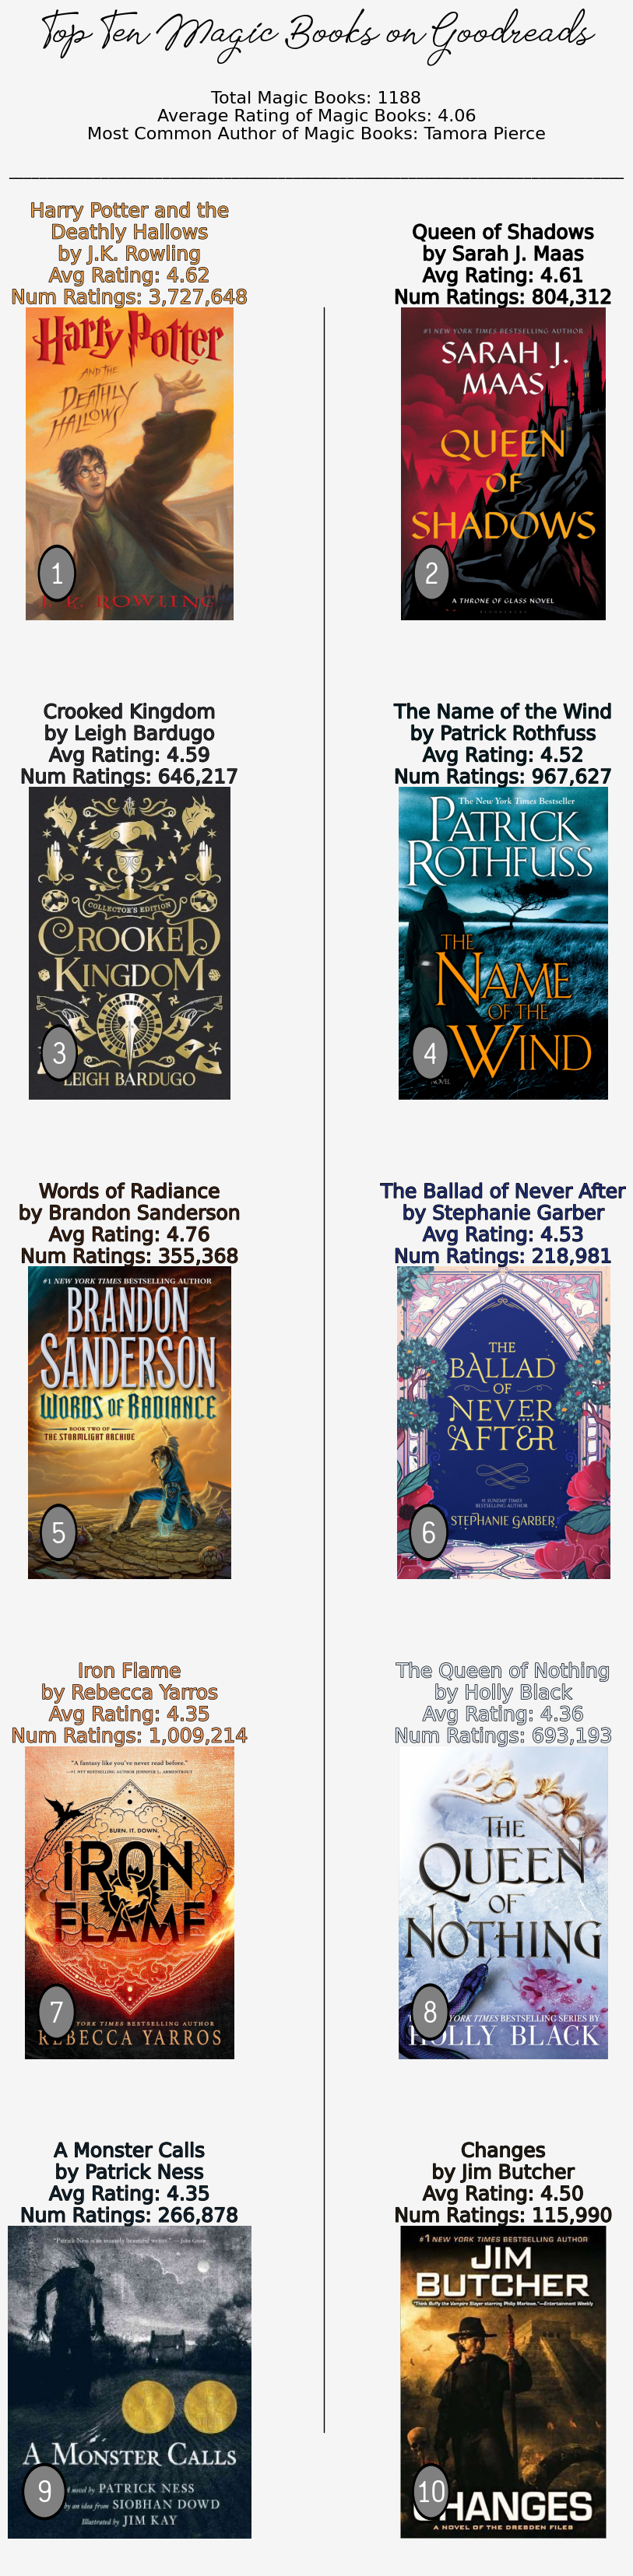

In [22]:
#generate infographic - top ten magic books
fig = plt.figure(figsize=(20, 35), facecolor='whitesmoke') 
fig.suptitle('Top Ten Magic Books on Goodreads', fontsize=26, color='black', fontproperties=font_properties, y=0.99)

stats_text = (f"Total Magic Books: {total_magic_books}\n"
              f"Average Rating of Magic Books: {avg_rating_magic_books:.2f}\n"
              f"Most Common Author of Magic Books: {most_common_author_magic_books}")

fig.text(0.5, 0.95, stats_text, ha='center', va='center', fontsize=16, color='black')

#divider
fig.text(0.5, 0.93, "_" * 80, ha='center', va='center', color='black', fontsize=14)

#subplots for the book covers and information
fig.subplots_adjust(hspace=0.4, top=0.88) 
axs = fig.subplots(5, 2, gridspec_kw={'height_ratios': [3, 3, 3, 3, 3], 'wspace': 0.5}) 
plt.rcParams.update({'font.family': 'Palatino Linotype'})

for idx, (ax, (index, row)) in enumerate(zip(axs.flatten(), top_magic_books_df.iterrows())):
    book_name = wrap_text(row['book_title'], width=25)
    author = row['author']
    avg_rating = row['average_rating']
    num_ratings = row['num_ratings']
    cover_image_uri = row['cover_image_uri']

    try:
        response = requests.get(cover_image_uri)
        img = Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Error loading image: {e}")
        continue

    dominant_color = get_dominant_color(cover_image_uri)
    hex_color = rgb_to_hex(dominant_color)

    ax.imshow(img)
    ax.axis('off')  
    
    ax.set_aspect('equal', adjustable='datalim')

    circle_radius = 0.08
    circle_border_radius = 0.09
    circle_x = 0.15
    circle_y = 0.15
    circle_color = 'gray'
    circle_border_color = 'black'
    
    circle_border = Circle((circle_x, circle_y), circle_border_radius, color=circle_border_color, transform=ax.transAxes, zorder=5)
    circle = Circle((circle_x, circle_y), circle_radius, color=circle_color, transform=ax.transAxes, zorder=6)
    
    ax.add_patch(circle_border)
    ax.add_patch(circle)
    adjustment = 0.01  
    ax.text(circle_x, circle_y + adjustment, str(idx + 1), color='white', fontsize=30, ha='center', va='center', transform=ax.transAxes, zorder=7, fontproperties=font_properties2)

    text = (f"{book_name}\nby {author}\n"
            f"Avg Rating: {avg_rating:.2f}\n"
            f"Num Ratings: {num_ratings:,}")
    
    title_text = ax.set_title(text, fontsize=18, pad=1, color=hex_color)
    title_text.set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                 path_effects.Normal()])
    
    #divider between books - not used/transparent
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="7%", pad=0.1)
    cax.plot([0, 1], [1, 1], color='none', linewidth=0)
    cax.axis('off')

#vertical divider line
fig.add_artist(plt.Line2D([0.505, 0.505], [0.1, 0.88], color='black', linewidth=1, transform=fig.transFigure))

#position of the subplots within the figure
plt.subplots_adjust(left=0.3, right=0.70, top=0.88, bottom=0.05)
#plt.savefig('top_10_magic_books_infographic.png', dpi=300, bbox_inches='tight')
plt.show()